# Homework 4 (84 pts)

## Overview
This homework assignment is divided into two parts: regionalization and exploring how spatial regression can incorporate space into regression analysis. Although numerous variations of spatial regression are available in lecture examples and online resources, this assignment will only focus on the most commonly used models: slx, spatial error, and spatial lag models.

The primary objective of this assignment is to gain a deeper understanding of regionalization, spatial regression, and their practical application. By working with census data in NYC, you will gain insight into how spatially related areas can be clustered. Additionally, by analyzing Airbnb data in NYC, you will learn how spatial variables can impact regression outcomes and how to incorporate them into your analysis. 

## Grading
Each exercise will be graded based on the following rubrics:
- 2 points. Completed the task, presented the expected results, and codes were well documented and explained.
- 1 point. Completed the task with some disparity from the expected results.
- 0 point. Did not complete the excercise.

## Late submission policy
For late submission, every extra day after the due date will lead to 20% off of your points. Less than a day will be counted as one day. All submissions after the TA team posts the answers will not be accepted.

In [1]:
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
from shapely.geometry import shape
import cenpy

/var/folders/tl/kq7bhnbd4yxd5mt28m9t8g100000gn/T/ipykernel_54873/2486374233.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


## Regionalization
### 1. Retrieve and Clean Data (6 pts)
For the first section of this assignment, census data at the census tract level will be utilized. Similar to homework 2, you will retrieve census data using the 2015-2019 5-year estimate from the American Community Survey. Only NYC will be downloaded with the following variables: 'B19013_001E', 'B25077_001E', 'B15003_001E','B15003_022E', 'B02001_001E', 'B02001_002E', 'B25008_001E', 'B25008_003E', 'B11001_001E', 'B11001_006E', 'B25018_001E', 'B19083_001E',  'B01002_001E',  and 'B08012_001E'. The retrieved data will be stored in a dataframe named **acs_data**. (2 pts)

In [6]:
# insert your code here
import cenpy
acs_cp = cenpy.products.ACS(2019)
acs_data = acs_cp.from_place('New York, NY', level='tract', variables = ['B19013_001E', 'B25077_001E', 'B15003_001E','B15003_022E', 'B02001_001E', 'B02001_002E', 'B25008_001E', 'B25008_003E', 'B11001_001E', 'B11001_006E', 'B25018_001E', 'B19083_001E',  'B01002_001E',  'B08012_001E'])
acs_data.head()

Matched: New York, NY to New York city within layer Incorporated Places


/var/folders/tl/kq7bhnbd4yxd5mt28m9t8g100000gn/T/ipykernel_54873/2389341684.py:5: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  acs_data = acs_cp.from_place('New York, NY', level='tract', variables = ['B19013_001E', 'B25077_001E', 'B15003_001E','B15003_022E', 'B02001_001E', 'B02001_002E', 'B25008_001E', 'B25008_003E', 'B11001_001E', 'B11001_006E', 'B11001_012E', 'B25018_001E', 'B19083_001E',  'B01002_001E',  'B08012_001E'])


,GEOID,geometry,B01002_001E,B02001_001E,B02001_002E,B08012_001E,B11001_001E,B11001_006E,B15003_001E,B15003_022E,B19013_001E,B19083_001E,B25008_001E,B25008_003E,B25018_001E,B25077_001E,state,county,tract
0,36085020801,"POLYGON ((-8262278.990 4946228.710, -8261996.3...",40.5,8498.0,8023.0,4042.0,3230.0,444.0,6256.0,1116.0,100543.0,0.4381,8485.0,1114.0,6.0,461000.0,36,085,020801
1,36085017012,"POLYGON ((-8257822.870 4945745.990, -8257700.4...",43.6,4321.0,3882.0,1753.0,1681.0,165.0,3288.0,681.0,89273.0,0.4374,4321.0,752.0,6.0,543500.0,36,085,017012
2,36085031901,"POLYGON ((-8256173.450 4957701.750, -8256171.1...",28.7,2816.0,1090.0,889.0,1051.0,290.0,1608.0,184.0,21250.0,0.6332,2816.0,1497.0,3.8,288500.0,36,085,031901
3,36085031902,"POLYGON ((-8256709.900 4959461.880, -8256698.5...",28.1,5343.0,1756.0,1994.0,1641.0,625.0,3010.0,601.0,46118.0,0.5606,5325.0,2528.0,5.2,328200.0,36,085,031902
4,36085014606,"POLYGON ((-8254594.160 4948740.120, -8254529.4...",41.5,5963.0,5683.0,3094.0,2313.0,226.0,4407.0,1071.0,103825.0,0.3779,5963.0,387.0,5.7,420600.0,36,085,014606


To generate new columns in acs_data, refer to [ACS Detailed Table Shells](https://www.census.gov/programs-surveys/acs/tec
hnical-documentation/table-shells.2019.html#list-tab-LO1F1MU1CQP3YOHD2T). These new columns will include median household value, percentage of white, percentage of renters, percentage of female-led households, percentage of bachelor's degree holders, median number of rooms, Gini index, median age, and travel time to work. (2 pts)

In [8]:
# insert your code here
acs_data['median_house_value'] = acs_data['B25077_001E']
acs_data['percent_white'] = acs_data['B02001_002E']/acs_data['B02001_001E']
acs_data['percent_renter'] = acs_data['B25008_003E']/acs_data['B25008_001E']
acs_data['female_led_households'] = acs_data['B11001_006E']/acs_data['B11001_001E']
acs_data['percent_bachelors'] = acs_data['B15003_022E']/acs_data['B15003_001E']
acs_data['median_rooms'] = acs_data['B25018_001E']
acs_data['gini_index'] = acs_data['B19083_001E']
acs_data['median_age'] = acs_data['B01002_001E']
acs_data['travel_time'] = acs_data['B08012_001E']
acs_data.head()

,GEOID,geometry,B01002_001E,B02001_001E,B02001_002E,B08012_001E,B11001_001E,B11001_006E,B15003_001E,B15003_022E,...,tract,median_house_value,percent_white,percent_renter,female_led_households,percent_bachelors,median_rooms,gini_index,median_age,travel_time
0,36085020801,"POLYGON ((-8262278.990 4946228.710, -8261996.3...",40.5,8498.0,8023.0,4042.0,3230.0,444.0,6256.0,1116.0,...,020801,461000.0,0.944104,0.131291,0.137461,0.178389,6.0,0.4381,40.5,4042.0
1,36085017012,"POLYGON ((-8257822.870 4945745.990, -8257700.4...",43.6,4321.0,3882.0,1753.0,1681.0,165.0,3288.0,681.0,...,017012,543500.0,0.898403,0.174034,0.098156,0.207117,6.0,0.4374,43.6,1753.0
2,36085031901,"POLYGON ((-8256173.450 4957701.750, -8256171.1...",28.7,2816.0,1090.0,889.0,1051.0,290.0,1608.0,184.0,...,031901,288500.0,0.387074,0.531605,0.275928,0.114428,3.8,0.6332,28.7,889.0
3,36085031902,"POLYGON ((-8256709.900 4959461.880, -8256698.5...",28.1,5343.0,1756.0,1994.0,1641.0,625.0,3010.0,601.0,...,031902,328200.0,0.328654,0.474742,0.380865,0.199668,5.2,0.5606,28.1,1994.0
4,36085014606,"POLYGON ((-8254594.160 4948740.120, -8254529.4...",41.5,5963.0,5683.0,3094.0,2313.0,226.0,4407.0,1071.0,...,014606,420600.0,0.953044,0.064900,0.097709,0.243022,5.7,0.3779,41.5,3094.0


In order to meet the requirements for later analysis, all nan values in acs_data should be replaced with 0. Following that, ONLY the above 9 variables should be rescaled using the `robust_scale()` function. The resulting scaled dataframe should be saved as **acs_scaled**. (2 pts)

In [10]:
# insert your code here
from sklearn.preprocessing import robust_scale
acs_data = acs_data.fillna(0)
acs_scaled = acs_data.copy()
acs_scaled[['median_house_value','percent_white','percent_renter','female_led_households','percent_bachelors','median_rooms','gini_index','median_age','travel_time']] = acs_scaled[['median_house_value','percent_white','percent_renter','female_led_households','percent_bachelors','median_rooms','gini_index','median_age','travel_time']].apply(robust_scale)

In [11]:
acs_scaled.head()

,GEOID,geometry,B01002_001E,B02001_001E,B02001_002E,B08012_001E,B11001_001E,B11001_006E,B15003_001E,B15003_022E,...,tract,median_house_value,percent_white,percent_renter,female_led_households,percent_bachelors,median_rooms,gini_index,median_age,travel_time
0,36085020801,"POLYGON ((-8262278.990 4946228.710, -8261996.3...",40.5,8498.0,8023.0,4042.0,3230.0,444.0,6256.0,1116.0,...,020801,-0.280031,1.063150,-1.132916,-0.087127,-0.092667,1.461538,-0.182287,0.440367,2.170452
1,36085017012,"POLYGON ((-8257822.870 4945745.990, -8257700.4...",43.6,4321.0,3882.0,1753.0,1681.0,165.0,3288.0,681.0,...,017012,-0.064119,0.978513,-1.035026,-0.318026,0.128476,1.461538,-0.190312,0.819572,0.189920
2,36085031901,"POLYGON ((-8256173.450 4957701.750, -8256171.1...",28.7,2816.0,1090.0,889.0,1051.0,290.0,1608.0,184.0,...,031901,-0.731484,0.031549,-0.216126,0.726292,-0.585025,-0.230769,2.054457,-1.003058,-0.557647
3,36085031902,"POLYGON ((-8256709.900 4959461.880, -8256698.5...",28.1,5343.0,1756.0,1994.0,1641.0,625.0,3010.0,601.0,...,031902,-0.627584,-0.076642,-0.346353,1.342746,0.071135,0.846154,1.222127,-1.076453,0.398443
4,36085014606,"POLYGON ((-8254594.160 4948740.120, -8254529.4...",41.5,5963.0,5683.0,3094.0,2313.0,226.0,4407.0,1071.0,...,014606,-0.385763,1.079705,-1.284961,-0.320654,0.404871,1.230769,-0.872456,0.562691,1.350205


### 2. Analyze Data (2 pts)
Despite collecting all variables for each census tract, the underlying spatial characteristics are still uncertain. To confirm the applicability of regionalization to this dataset, it is necessary to determine whether spatial autocorrelation exists in these variables.

To do this, create a spatial weight matrix using the Queen method and calculate the global Moran's I for all 9 variables. Then, present your results in a dataframe that displays Moran's I and P-value for each variable. (2 pts)

In [13]:
from esda.moran import Moran
from libpysal.weights import Queen

w = Queen.from_dataframe(acs_scaled)
w.transform = 'r'

moran_list = []
for i in acs_scaled.columns[-9:]:
    moran = Moran(acs_scaled[i], w)
    moran_list.append([i, moran.I, moran.p_sim])
moran_df = pd.DataFrame(moran_list, columns = ['variable', 'Moran I', 'P-value'])
moran_df


/Users/yucheng/opt/anaconda3/envs/gds_py/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 229.
  warnings.warn(message)


('WARNING: ', 229, ' is an island (no neighbors)')


,variable,Moran I,P-value
0,median_house_value,0.525214,0.001
1,percent_white,0.769866,0.001
2,percent_renter,0.614226,0.001
3,female_led_households,0.589929,0.001
4,percent_bachelors,0.596314,0.001
5,median_rooms,0.431719,0.001
6,gini_index,0.240902,0.001
7,median_age,0.241798,0.001
8,travel_time,0.348324,0.001


### 3. Regionalization (6 pts)
Create the regionalization model based on **acs_scaled** by specifying the linkage as "ward" and the number of clusters as 5. (2 pts)

In [18]:
# insert your code here
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(linkage='ward', n_clusters=5)
model.fit(acs_scaled.iloc[:,-9:])
acs_scaled['ward5'] =  model.labels_
acs_scaled.head()

,GEOID,geometry,B01002_001E,B02001_001E,B02001_002E,B08012_001E,B11001_001E,B11001_006E,B15003_001E,B15003_022E,...,median_house_value,percent_white,percent_renter,female_led_households,percent_bachelors,median_rooms,gini_index,median_age,travel_time,ward5
0,36085020801,"POLYGON ((-8262278.990 4946228.710, -8261996.3...",40.5,8498.0,8023.0,4042.0,3230.0,444.0,6256.0,1116.0,...,-0.280031,1.063150,-1.132916,-0.087127,-0.092667,1.461538,-0.182287,0.440367,2.170452,1
1,36085017012,"POLYGON ((-8257822.870 4945745.990, -8257700.4...",43.6,4321.0,3882.0,1753.0,1681.0,165.0,3288.0,681.0,...,-0.064119,0.978513,-1.035026,-0.318026,0.128476,1.461538,-0.190312,0.819572,0.189920,1
2,36085031901,"POLYGON ((-8256173.450 4957701.750, -8256171.1...",28.7,2816.0,1090.0,889.0,1051.0,290.0,1608.0,184.0,...,-0.731484,0.031549,-0.216126,0.726292,-0.585025,-0.230769,2.054457,-1.003058,-0.557647,4
3,36085031902,"POLYGON ((-8256709.900 4959461.880, -8256698.5...",28.1,5343.0,1756.0,1994.0,1641.0,625.0,3010.0,601.0,...,-0.627584,-0.076642,-0.346353,1.342746,0.071135,0.846154,1.222127,-1.076453,0.398443,4
4,36085014606,"POLYGON ((-8254594.160 4948740.120, -8254529.4...",41.5,5963.0,5683.0,3094.0,2313.0,226.0,4407.0,1071.0,...,-0.385763,1.079705,-1.284961,-0.320654,0.404871,1.230769,-0.872456,0.562691,1.350205,1


Using the results from your model, create a choropleth map of the 5 clusters. Remember to add a legend. (2 pts)

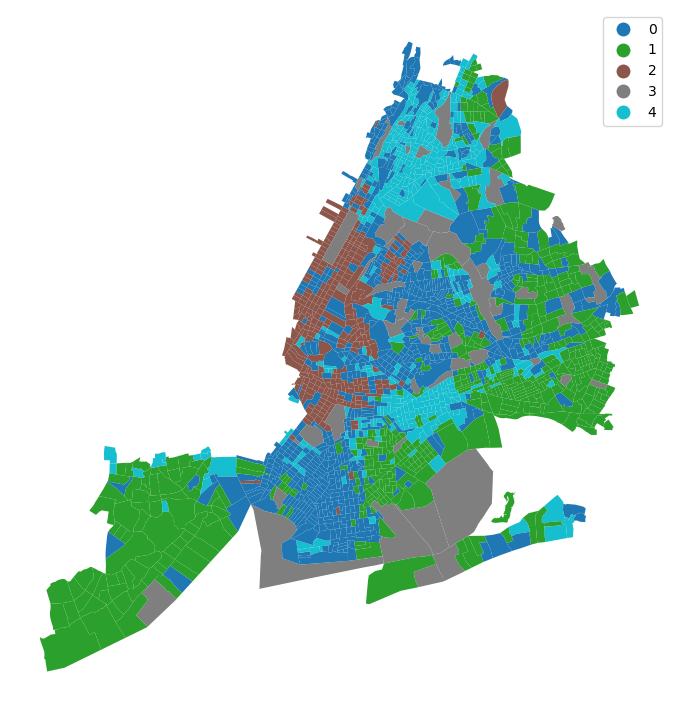

In [19]:
# insert your code here
import matplotlib.pyplot as plt
f, ax = plt.subplots(1, figsize=(9, 9))
acs_scaled.plot(column='ward5', categorical=True, legend=True, ax=ax, linewidth = 0)
ax.set_axis_off()
plt.show()


Regionalization results heavily rely on the spatial constraint, which is determined by the spatial weight matrix. To explore the impact of the spatial weight matrix on the results, try a new spatial matrix using 4 nearest neighbors.

Using ward linkage and 5 clusters specified in your function, generate a new regionalization model. Then, plot the new clusters with a legend. (2 pts)

In [ ]:
# insert your code here

### 4. Evaluate Regionalization Models (6 pts)
To determine which regionalization model is "better," you can compare your models based on measures of geographical coherence and goodness of fit.
### 4.1 Geographical Coherence (2 pts)
Compute the isoperimetric quotient for each cluster in both models. Then, concatenate the isoperimetric quotients into a new dataframe with columns labeled as *ward5wq* and *ward5wknn* and rows representing the 5 clusters. Show your dataframe. (2 pts)

In [ ]:
# insert your code here

### 4.2 Feature Coherence (goodness of fit) (4 pts)
Another measurement that can be used to evaluate the quality of the regionalization models is the `metrics.calinski_harabasz_score()` (CH) function, which calculates the ratio of within-cluster variance to between-cluster variance. Compute the CH score for both the original model with Queen spatial weight matrix and the model with 4 nearest neighbors. Then, report the CH scores of both models. (2 pts)

In [ ]:
# insert your code here

Based on Geographical Coherence and Feature Coherence, which regionalization model performs better? And why? (2 pts)

## Spatial Regression
The second section uses Airbnb listing in Manhattan. Since you have been familiar with the datasets, codes are provided for retrieving data. 
### 1. Read Data

In [ ]:
url_qr = "https://data.cityofnewyork.us/resource/63ge-mke6.json?$where=BoroName='Manhattan'"
ct = pd.read_json(url_qr)
ct['the_geom'] = ct['the_geom'].apply(shape)
ct = gpd.GeoDataFrame(ct, geometry='the_geom').set_crs(epsg = 4326)

In [ ]:
listing_raw = pd.read_csv('http://data.insideairbnb.com/united-states/ny/new-york-city/2022-12-04/data/listings.csv.gz')
listing_raw.price = listing_raw.price.replace('[\$,]', '', regex=True).astype(float)
listing_g = gpd.GeoDataFrame(listing_raw, 
                             geometry = gpd.points_from_xy(listing_raw.longitude, 
                                                           listing_raw.latitude)).set_crs(epsg = 4326)
listing = gpd.tools.sjoin(listing_g, ct[['geoid', 'boroname', 'the_geom']], predicate="within", how='inner')
listing.info()

### 2. Clean and Visualize Data (24 pts)
### 2.1 Clean Data (8 pts)
Before proceeding with any regression analysis, it is always important to familiarize yourself with the data. One of the assumptions of Ordinary Least Squared (OLS) linear regression is that the underlying distribution of each variable should follow a normal distribution. One way to check for normality is by plotting the frequency of values in each variable using a histogram.

Make a histogram of *price* and answer whether it follows normal distribution in a separate markdown cell. (2 pts)

In [ ]:
# insert your code here

Notice that 0 may exist in *price* column, which makes no sense in real world because no Airbnb is offered for free. To confirm whether 0 exists, use `describe` function to check the numeric distribution of *price*. If yes, remove all rows with 0 in *price*. (2 pts)

In [ ]:
# insert your code here

In [ ]:
# insert your code here

For analytical purposes, it is common to transform highly skewed variables into data that appears to have a normal distribution. One commonly used transformation is to take the logarithm of the original variable.

Take the log value of *price* (named as *log_price*) and make a histogram plot of *log_price*. (2 pts). 

Does it look like a normal distribution? Answer in a separate markdown cell. (2 pts) 

In [ ]:
# insert your code here

### 2.2 Create Dummy Variables (12 pts)

Read [lecture example of San Diego Airbnb](https://geographicdata.science/book/notebooks/11_regression.html#exogenous-effects-the-slx-model) and you'll notice that both room type and property type can be important in determining listing prices. However, in order to include this information in a regression analysis, you need to transform these text variables into dummy variables.  

Following the same step in the example, you can create four dummy variables (rt_Entire_home/apt, rt_Hotel_room, rt_Private_room, and rt_Shared_room) for room type. Show your **rt** dataframe. (2 pts)

In [ ]:
# insert your code here

Another variable that may be important in determining Airbnb listing prices is whether the host has been verified with their identity. Similarly, you can create a dummy variable to record this information. Since only t (standing for ture) and f (standing for false) are stored in *host_id_verified*, you can only rename t as the new *host_id_verified* in dataframe **host**. Show your dataframe **host**. (2 pts)

In [ ]:
# insert your code here

Though [the San Diego example](https://geographicdata.science/book/notebooks/11_regression.html#exogenous-effects-the-slx-model) provides a method to create dummy variables for property type, the code cannot be directly used in the New York City Airbnb dataset because the property type texts are recorded differently. With the modified *simplify* function, create a new column named *property_group* in **listing** dataframe. Next you can create dummy variables in dataframe **pg**. Show your dataframe **pg**. (2 pts) 

In [ ]:
def simplify(p):
    bigs = ['apartment', 'condo', 'townhouse', 'resort']
    p_lst = p.split()
    for p in p_lst:
        if p in bigs:
            return p

# insert your code here

Another important variable that affects listing prices is the number of bathrooms in each listing, which is stored as text in the **listing** dataframe with null values. To prepare the data for analysis, replace all null values in the *bathrooms_text* column with 0. 

Next, you can create a function called *find_bath* like *simplify*. *find_bath* function will split the text in *bathrooms_text* and return the number of bathrooms in float. (2 pts) 

Apply this function to *bathrooms_text* to create a new column *bathrooms* in **listing**. (2 pts)

In [ ]:
# insert your code here

Merge dataframe **rt**, **host**, and **pg** to **listing**. Show the infomation of your new **listing**. (2 pts)

In [ ]:
# insert your code here

### 2.3 Create Spatial Variable (Distance to City Center) (4 pts)
Given the spatial nature of NYC listing, adding spatial variable can help improve the regression performance. One tpical spatial variable is the distance to city center. Though there is no concensus on where exactly the city center is in NYC, you can use the median center as a proxy. Recall what you've done in Homework 2 to create the median center and name it as *city_center*. (2 pts) 

In [ ]:
# insert your code here

To calculate distance in meters from coordinates, you must first transform the crs into the USA Contiguous Albers Equal Area (provided below) because this datum is measured by meters. Refer to [data cleaning process for San Diego Airbnb](https://geographicdata.science/book/data/airbnb/regression_cleaning.html) and generate *d2center* column in **listing**. (2 pts)

In [ ]:
tgt_crs = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 "\
          "+lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs"

In [ ]:
from shapely import Point
from scipy.spatial.distance import cdist

center = gpd.GeoSeries(Point(city_center[0], city_center[1]), crs=listing.crs).to_crs(tgt_crs)[0]
center = (center.x, center.y)

d2b = lambda pt: cdist([(pt.x, pt.y)], [center])[0][0]/1000
# insert your code here

## 3. Regressions (40 pts)
### 3.1 Linear Regression (6 pts)
The dependent variables used here include "accommodates", "bedrooms", "bathrooms", "host_id_verified", "rt_Shared_room", "pg_apartment", "pg_condo", "pg_townhouse", "pg_resort", "d2center" and the independent variable is "log_price". Create a new dataframe **X** which contains all dependent variables and *geometry* in **listing**. Remove all null values in **X** and show the shape of **X**. (2 pts)

In [ ]:
# insert your code here

Create another series **y** storing *log_price*. Remember to keep **X** and **y** in the same number of rows. Show the number of rows of **y**. (2 pts)

In [ ]:
# insert your code here

Run OLS based on your **X** and **y**. Interpret your results: Do these variables explain the listing price well? Why or why not? (2 pts)

In [ ]:
# insert your code here

### 3.2 Verification (8 pts)
The above OLS model provides a base model for further analysis. From all perspectives, this model should be revised to better represent the reality. To verify whether space plays an important role in explaining listing price, the residuals of OLS can help.

Create a new column *residual* in dataframe **X**. Plot the residuals with 5 quantile using your color. Add legend and basemap to your map. (2 pts)

In [ ]:
# insert your code here

How do you interpret the spatial distribution of your OLS residuals? Is it clustered or scattered across NYC? (2 pts)

In addition to visual check, Moran's I provides more proof on spatial distribution. Create a row-standardized spatial weight matrix (named as wd) from distance-based knn method. Use 4 as the number of neighbors. (2 pts)

In [ ]:
# insert your code here

Next, you can check the global Moran's I with the residual. What is the value? And how can you conclude the spatial characteristics of the residual? (2 pts)

In [ ]:
# insert your code here

### 3.3 Exogenous Effect -- SLX Model (8 pts)
With spatial clustering exists in the OLS residuals, it implies that adding spatial components to your regression can improve the model performance. Assuming that there is no interaction between the dependent variables and their spatial lags, SLX model can be built using `spreg.OLS` function as the spatial lags of the dependent variables are treated as exogenous variables.

Create only spatial lags for dummy variables of property types condo, townhouse, and resort. Rename the spatial lags by adding "w_" before their original names. Store these new variables in dataframe **wx**. (2 pts)  

In [ ]:
# insert your code here

Create a new dataframe **slx_exog** by merging **X** and **wx**. Now you can apply `spreg.OLS` function to the new dataframe and fit the model. Present your model results below. (2 pts)

In [ ]:
# insert your code here

Compare the result with the OLS result. Is there any difference with the coefficients of each variable? Are there any new variables? Are these coefficients all statistically significant? (2 pts)

Does slx model improve the performance of OLS? (2 pts)

### 3.4 Spatial Error Regression (6 pts)
Another assumption is that spatial clustering exists only in the error terms of OLS model. Use the same dependent and independ variables and spatial weight matrix *wd* for your spatial error model. Report the model results below. (2 pts)

In [ ]:
# insert your code here

Compare the result with the OLS result. Is there any difference with the coefficients of each variable? Are these coefficients all statistically significant? (2 pts) 

What is the meaning of lambda? Does spatial error model improve the performance of OLS? (2 pts) 

### 3.5 Spatial Lag Regression (6 pts)

You can also assume that spatial clustering exists in the dependent variables of the OLS model. Use the same dependent and independ variables and spatial weight matrix *wd* for your spatial lag model. Report the model results below. (2 pts)

In [ ]:
# insert your code here

Compare the result with the OLS result. Is there any difference with the coefficients of each variable? Are these coefficients all statistically significant? (2 pts) 

What is the meaning of W_log_price? Does spatial lag model improve the performance of OLS? (2 pts)

### 3.6 Other model (6 pts)
To better improve the model performance, what else will you do? For example, you can create a new spatial variable and pick up one of the spatial models to build a new model. Show how you create the new spatial variable (2 pts) and new model results (2 pts). 

How does your variable improve the models? Answer in a separate markdown cell. (2 pts)